<a href="https://colab.research.google.com/github/Jassmine11/cfpb-complaints-project/blob/main/CFPB_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load and inspect the data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install gdown


In [3]:
import gdown

url = "https://drive.google.com/uc?id=1UCLpDLu_kzoSKGWer8Hp8DXGE0yy3XWu"
output = "consumer_complaints.csv"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1UCLpDLu_kzoSKGWer8Hp8DXGE0yy3XWu
From (redirected): https://drive.google.com/uc?id=1UCLpDLu_kzoSKGWer8Hp8DXGE0yy3XWu&confirm=t&uuid=7dba68d7-4c63-4497-a57e-dd8f73885706
To: /content/consumer_complaints.csv
100%|██████████| 1.41G/1.41G [00:20<00:00, 69.6MB/s]


'consumer_complaints.csv'

In [4]:
import gdown
import zipfile
import os
import pandas as pd

# Step 1: Download the ZIP file from Google Drive
url = "https://drive.google.com/uc?id=1UCLpDLu_kzoSKGWer8Hp8DXGE0yy3XWu"
output_zip = "consumer_complaints.zip"
gdown.download(url, output_zip, quiet=False)

# Step 2: Unzip the file
extract_folder = './consumer_complaints/'
os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 3: Check extracted files
extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)

# Step 4: Load the CSV (assuming single CSV in zip)
csv_file = os.path.join(extract_folder, extracted_files[0])

# Step 5: Read a sample from the CSV (to avoid memory issues)
df_sample = pd.read_csv(csv_file, nrows=100000)
print(df_sample.head())

# Keep raw data untouched
df_raw = df_sample.copy()

# Use df_clean as the single working dataframe
df_clean = df_sample.copy()

print("Working dataset shape:", df_clean.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1UCLpDLu_kzoSKGWer8Hp8DXGE0yy3XWu
From (redirected): https://drive.google.com/uc?id=1UCLpDLu_kzoSKGWer8Hp8DXGE0yy3XWu&confirm=t&uuid=0c66f0b4-cd10-4c4c-a2a5-c28c531866ed
To: /content/consumer_complaints.zip
100%|██████████| 1.41G/1.41G [00:20<00:00, 70.0MB/s]


Extracted files: ['complaints.csv']
  Date received                                            Product  \
0    2025-07-20                                    Debt collection   
1    2025-08-07  Credit reporting or other personal consumer re...   
2    2025-08-06  Credit reporting or other personal consumer re...   
3    2025-08-07  Credit reporting or other personal consumer re...   
4    2025-08-06  Credit reporting or other personal consumer re...   

        Sub-product                                 Issue  \
0       Rental debt             Electronic communications   
1  Credit reporting           Improper use of your report   
2  Credit reporting  Incorrect information on your report   
3  Credit reporting           Improper use of your report   
4  Credit reporting           Improper use of your report   

                                           Sub-issue  \
0  You told them to stop contacting you, but they...   
1      Reporting company used your report improperly   
2       

## Step 5: Data Wrangling Overview

In this section, I clean and prepare the CFPB consumer complaints dataset for NLP modeling
and Retrieval-Augmented Generation (RAG). This includes handling missing values, duplicates,
outliers, and preparing a clean dataset for downstream modeling.


In [5]:
# Check missing values
df_clean.isna().mean().sort_values(ascending=False).head(20)

,0
Consumer disputed?,0.97061
Tags,0.94949
Consumer complaint narrative,0.73139
Company public response,0.68471
Consumer consent provided?,0.49103
Sub-issue,0.04514
Sub-product,0.00980
State,0.00332
ZIP code,0.00110
Date received,0.00000


In [6]:
drop_cols = [
    "Consumer disputed?",
    "Tags",
    "Company public response",
    "Consumer consent provided?"
]

df_clean = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns])


In [7]:
TEXT_COL = "Consumer complaint narrative"

df_clean = df_clean[df_clean[TEXT_COL].notna()].copy()
df_clean[TEXT_COL] = df_clean[TEXT_COL].astype(str).str.strip()
df_clean = df_clean[df_clean[TEXT_COL] != ""]


In [8]:
fill_unknown = ["Sub-issue", "Sub-product", "State", "ZIP code"]

for col in fill_unknown:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna("Unknown")


In [9]:
# Check data types and summary info
#df_clean.info()

In [10]:
# Check for missing values and duplicates
#df_clean.isnull().sum()
#df_clean.duplicated().sum()

In [11]:
# check shape ( rows and columns)
# look at column names
# check data types and missing values

print("Shape:", df_clean.shape)
print("\nColumns:", df_clean.columns.tolist())
print("\nData types:\n", df_clean.dtypes)
print("\nMissing values per column:\n", df_clean.isnull().sum())


Shape: (26861, 14)

Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company', 'State', 'ZIP code', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Complaint ID']

Data types:
 Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company                         object
State                           object
ZIP code                        object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Complaint ID                     int64
dtype: object

Missing values per column:
 Date received                   0
Product                         0
Sub-product                     0
Issue                      

### Post-Cleaning Data Summary

After data wrangling:
- The dataset contains 26,861 complaint records with complete narrative text.
- All remaining columns have zero missing values.
- High-missing and low-utility columns were removed earlier.
- The dataset is now suitable for NLP modeling and Retrieval-Augmented Generation (RAG).

This cleaned dataset will be used in subsequent steps for text classification,
embedding generation, and compliance-aware analysis.


In [12]:
before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
print("Duplicates removed:", before - df_clean.shape[0])


Duplicates removed: 0


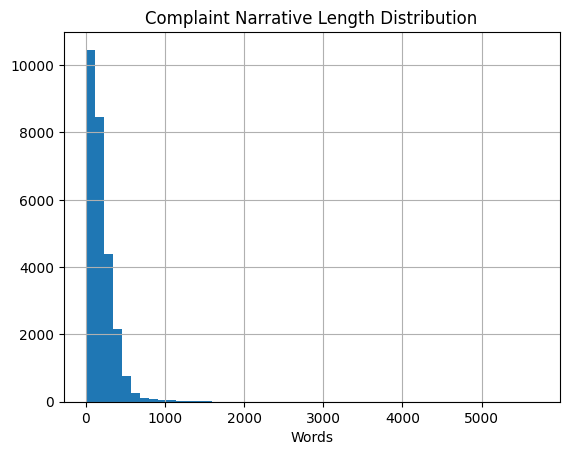

In [14]:
import matplotlib.pyplot as plt
df_clean["text_len_words"] = df_clean["Consumer complaint narrative"].str.split().str.len()
df_clean["text_len_words"].describe()

df_clean["text_len_words"].hist(bins=50)
plt.title("Complaint Narrative Length Distribution")
plt.xlabel("Words")
plt.show()


In [15]:
df_clean.to_csv("cfpb_cleaned_step5.csv", index=False)


In [16]:
# Flag short and long complaint narratives
SHORT_THRESHOLD = 20
LONG_THRESHOLD = 800

df_clean["is_short"] = df_clean["text_len_words"] < SHORT_THRESHOLD
df_clean["is_long"] = df_clean["text_len_words"] > LONG_THRESHOLD

# Percentage of flagged records
(df_clean[["is_short", "is_long"]].mean() * 100).rename("percent_flagged")


,percent_flagged
is_short,2.326793
is_long,0.997729


### Outlier Analysis (Complaint Narrative Length)

The complaint narrative length distribution is highly right-skewed.
Most complaints are under a few hundred words, while a small number
extend to several thousand words.

Very short complaints (<20 words) may lack sufficient semantic content
for NLP modeling and may be excluded from certain models.

Very long complaints (>800 words) may exceed transformer or LLM token
limits. These will not be removed; instead, they will be chunked in
later steps to support Retrieval-Augmented Generation (RAG).

For this step, outliers are flagged rather than blindly removed.


In [17]:
# Final duplicate check (even if zero)
df_clean = df_clean.drop_duplicates()

# Export cleaned dataset
df_clean.to_csv("cfpb_cleaned_step5.csv", index=False)


### Outlier Summary

Approximately 2.3% of complaint narratives are very short (<20 words) and may contain
limited semantic information for modeling.

Approximately 1.0% of narratives are very long (>800 words) and may exceed token limits
for transformer-based models or LLMs.

Rather than removing these records, outliers are flagged for special handling in later
steps. Short narratives may be excluded from certain models, while long narratives will
be chunked to support Retrieval-Augmented Generation (RAG).


In [18]:
df_clean["text_len_words"].describe()


,text_len_words
count,26861.000000
mean,191.438926
std,182.924825
min,2.000000
25%,83.000000
50%,148.000000
75%,259.000000
max,5701.000000


**Data** **Cleaning**


In [20]:
#Fill common missing values
df = df_clean.copy()
for col in ['Sub-product', 'Sub-issue', 'ZIP code', 'State']:
    df_clean[col] = df[col].fillna('Unknown')

### Narrative Length Statistics

The average complaint narrative length is approximately 191 words, with a median of 148 words.
This confirms that most narratives are of moderate length and suitable for NLP modeling.

The distribution is right-skewed, with a small number of very long narratives (maximum 5,701 words),
which will require chunking in later LLM-based steps. Very short narratives are relatively rare and
have already been flagged for potential exclusion in certain models.


## Conclusion

In this step, the CFPB consumer complaints dataset was successfully cleaned, wrangled,
and validated in preparation for downstream NLP modeling and Retrieval-Augmented
Generation (RAG).

After sampling the raw dataset to manage memory constraints, rows without complaint
narratives were removed, as narrative text is essential for the objectives of this project.
Columns with very high missingness and limited analytical value were dropped, while
categorical metadata fields with low missingness were filled with the label "Unknown"
to preserve records and explicitly represent missing information.

Duplicate records were removed, and lightweight text normalization was applied.
Outliers were analyzed using complaint narrative length, revealing a right-skewed
distribution with a small percentage of very short and very long narratives. Rather
than removing these records, they were flagged for special handling in later modeling
steps, such as exclusion of short narratives or chunking of long narratives for LLM-based
retrieval.

The final cleaned dataset contains 26,861 high-quality complaint narratives with no
missing values in retained columns. This dataset is now well-suited for baseline text
classification, semantic retrieval, and compliance-aware RAG pipelines in subsequent
capstone steps.


# Step 6 — Baseline Model (TF-IDF + Logistic Regression)

This notebook establishes a baseline text classification model using the cleaned
CFPB complaint narratives. The goal is to create a simple, interpretable model
that provides a performance reference for more advanced models later in the capstone.


In [21]:
# Code — Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [22]:
#Code — Load cleaned dataset
df = pd.read_csv("cfpb_cleaned_step5.csv")

TEXT_COL = "Consumer complaint narrative"
TARGET_COL = "Product"

print(df.shape)
df[[TEXT_COL, TARGET_COL]].head()


(26861, 17)


,Consumer complaint narrative,Product
0,"On XX/XX/XXXX, I received a personal loan from...","Credit reporting, credit repair services, or o..."
1,My line of credit was used by an identity thie...,Credit card
2,I am writing to formally dispute the accuracy ...,Credit reporting or other personal consumer re...
3,I had a SPARK business credit card with Capita...,Credit card
4,I AM A XXXX XXXX XXXX XXXX. I RECENTLY LEARNED...,Debt collection


Markdown — Train/test split

## Train/Test Split

The dataset is split into training and testing sets to evaluate
generalization performance. Stratification is used to preserve
class distributions.


In [23]:
#Code — Split data
X = df[TEXT_COL]
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (21488,)
Test size: (5373,)


## TF-IDF Vectorization

TF-IDF converts complaint narratives into numerical features
based on term importance across the corpus.


In [24]:
# Code — Vectorize text
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape


(21488, 50000)

## Baseline Classifier: Logistic Regression

Logistic Regression is used as a strong linear baseline for text classification.
Class weights are balanced to address label imbalance.


In [25]:
#Code — Train model
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

model.fit(X_train_tfidf, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [26]:
#Code — Evaluate baseline
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.7053787455797506

Classification Report:

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.39      0.41      0.40        29
                                                 Checking or savings account       0.72      0.77      0.74       264
                                                               Consumer Loan       0.14      0.07      0.09        15
                                                                 Credit card       0.45      0.55      0.49       176
                                                 Credit card or prepaid card       0.49      0.58      0.53       185
                                                            Credit reporting       0.17      0.61      0.27        51
                         Credit reporting or other personal consumer reports       0.86      0.75      0.80      2175
C

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# majority baseline
majority_class = y_train.value_counts().idxmax()
y_majority_pred = np.full_like(y_test, majority_class)

print("Majority baseline accuracy:",
      accuracy_score(y_test, y_majority_pred))


Majority baseline accuracy: 0.40480178671133443


## Conclusion

In this step, a baseline text classification model was developed to establish a
performance reference for the CFPB consumer complaints dataset. A naive majority-class
baseline achieved an accuracy of approximately 40%, reflecting the strong class
imbalance present in the data.

Using TF-IDF vectorization combined with a Logistic Regression classifier, the baseline
model achieved an accuracy of approximately 70% and a weighted F1-score of 0.71. This
represents a substantial improvement of over 30 percentage points compared to the
majority baseline, demonstrating that the model is learning meaningful linguistic
patterns from complaint narratives rather than relying solely on class frequency.

Performance is strongest for well-represented product categories such as credit
reporting, mortgage, and debt collection. The model performs less effectively on
rare product categories with very limited training samples, resulting in lower macro
F1-score and undefined precision for some classes. This behavior is expected for a
linear bag-of-words model and highlights the limitations of simple baselines when
handling semantic overlap and severe class imbalance.

Overall, this baseline provides a realistic and interpretable performance benchmark.
The observed limitations motivate the use of more expressive models, such as
transformer-based architectures and Retrieval-Augmented Generation (RAG), in subsequent
capstone steps to improve performance on minority classes and provide more
context-aware, evidence-grounded insights.
